Physics 105B Mathematical and Computational Physics Final Project  
6/13/23  
By: Po-Chang Chen

In [657]:
import numpy as np
import matplotlib.pyplot as plt
import scipy

The Metropolis-Hastings Algorithm is a method can be used to explore and find the parameters of a posterior distribution. 

The algorithm is a Markov chain Monte Carlo method that consists of an acceptance ratio $\alpha$, which is needed to determine whether or not each new point $x'$ from $Q(x'|x_0)$ should be used as the next point. Using a function $f(\vec x) \propto P(\vec x)$ where $P(\vec x)$ is the desired probability distribution, the acceptance ratio is $\alpha = f(\vec x')/f(\vec x_0)$. 

Since the goal is to move in the direction of increasing probability, if $\alpha \ge 1$, then $\vec x'$ is added to the walk. If $\alpha < 1$ then $\vec x'$ can either be accepted and added to the walk with probability $\alpha$ or rejected and the walk stays at $\vec x_0$ with probability $1-\alpha$.

Although the walk generally moves toward areas of increasing probability, it also has a nonzero chance to go in the direction of decreasing probability to help avoid getting stuck at local maxima. This process is repeated until the walk converges to some area. 

For this project I will use a data set data = signal + noise where the signal is the same as from HW2 problem 2, $A_0e^{g_0t}$ and the noise is a gaussian with standard deviation of $s$.

In [658]:
student_number = 16454873
np.random.seed(student_number)
g0 = np.random.uniform(1,2)
A0 = np.random.rand()
s = np.random.uniform(0.5,1.5)
print(f'A0 = {A0}, g0 = {g0}, s = {s}')

A0 = 0.34437829223451133, g0 = 1.9004981138156376, s = 1.4568339401333834


In [659]:
N = 100
t = np.linspace(0,5,N)
signal = A0*np.exp(g0*t)
noise = np.random.normal(0,s,100)
data = signal + noise

The proposal distribution $Q$ generates possible candidates for the next points in a random walk is needed. I will be using a Gaussian distribution with standard deviation $0.1$ for both variables centered at each data point of the data set to use as candidates.

In [660]:
def proposal_distribution(x0, x1):
    return np.random.normal((x0, x1), (0.00005, 0.00005), (2,))

In Bayesian statistics, Bayes theorem:
$P(A|B) = \dfrac{P(B|A)P(A)}{P(B)}$  
$P(A|B)$ is the posterior probability, or the probability of $A$ given evidence $B$.  
$P(B|A)$ is the likelihood function, or probability of $B$ given $A$ is true.  
$P(A)$ is the prior and $P(B)$ is the probabiilty of evidence $B$.

From a point $x_t$, to calculate the Metropolis acceptance ratio, the quantity $a = \frac{P(x')Q(x_t|x')}{P(x_t)Q(x'|x_t)}$ has to be found. However since $Q$ is a symmetric distribution, $a = \frac{P(x')}{P(x_t)}$.
The acceptance probability is $A = \mathrm{min}(1, a)$.

For this project, $P$, the target distribution, is the posterior, so using Bayes theorem, $P(x'|D)=\frac{P(D|x')P(x')}{P(D)}$ and $P(x_t|D)=\frac{P(D|x_t)P(x_t)}{P(D)}$. This means $a=\frac{P(D|x')P(x')}{P(D|x_t)P(x_t)}$.

For numerical stability (very small numbers), I will take the log of the likelihoods and priors. There are also no preferences for proposed and current values so the probability of priors will be $1$, with the logarithm of the priors being $0$. This means the acceptance condition can be rewritten as accept when $\log{P(D|x')} > \log{P(D|x_t)}$, else $x'$ with probability $a$ and $x_t$ with probability $1-a$.

In [661]:
def acceptance(log_prob_dist, proposed_step, current_step):
    proposed = log_prob_dist(proposed_step[0], proposed_step[1])
    current = log_prob_dist(current_step[0], current_step[1])
    if (proposed > current):
        acceptance_probability = 1
    else: 
        # taking the exponent for P(x')/P(xt)
        acceptance_probability = np.exp(proposed-current)
    return acceptance_probability

Since I am going to be using the same set of data as HW2, the posterior is already calculated there. I will run the HW2 code to show (because I will compare the Metropolis results to it later also).

In [662]:
def Prob(data,A,g,t,s=s):
    Prob = np.exp(-((data - A*np.e**(g*t))**2).sum())
    return Prob/(2*np.pi*s**2)**(100/2)

In [663]:
def chi_squared(A,g,t=t,data=data,s=s):
    noise = ((data - A*np.exp(g*t))**2).sum()
    return noise/(s**2)

The log of the posterier (below this) is the one I will use to run the Metropolis-Hastings algorithm.

In [664]:
def log_probability(A,g,t=t,data=data):
    return (-(data - A*np.exp(g*t))**2).sum()

In [665]:
from scipy.optimize import minimize
res = minimize(lambda X:chi_squared(X[0],X[1]), [0.35,1.9])
print(res)
# res = minimize(lambda X:Prob(data,X[0],X[1],t), [0.35,1.9])
# print(res)
fittedparams = res['x']

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 115.25597707874451
        x: [ 3.441e-01  1.901e+00]
      nit: 7
      jac: [-1.907e-04 -9.060e-05]
 hess_inv: [[ 3.135e-07 -1.907e-07]
            [-1.907e-07  1.164e-07]]
     nfev: 121
     njev: 37


In [666]:
chi_min_line=chi_squared(fittedparams[0],fittedparams[1])

In [667]:
a_r = np.linspace(fittedparams[0]-0.0025,fittedparams[0]+0.0025,1000)
g_r = np.linspace(fittedparams[1]-0.002,fittedparams[1]+0.002,1000)
A,G = np.meshgrid(a_r,g_r)
logP = np.zeros(A.shape)
for i in range(1000):
    for j in range(1000):
        logP[i,j]=chi_squared(A[i,j],G[i,j])

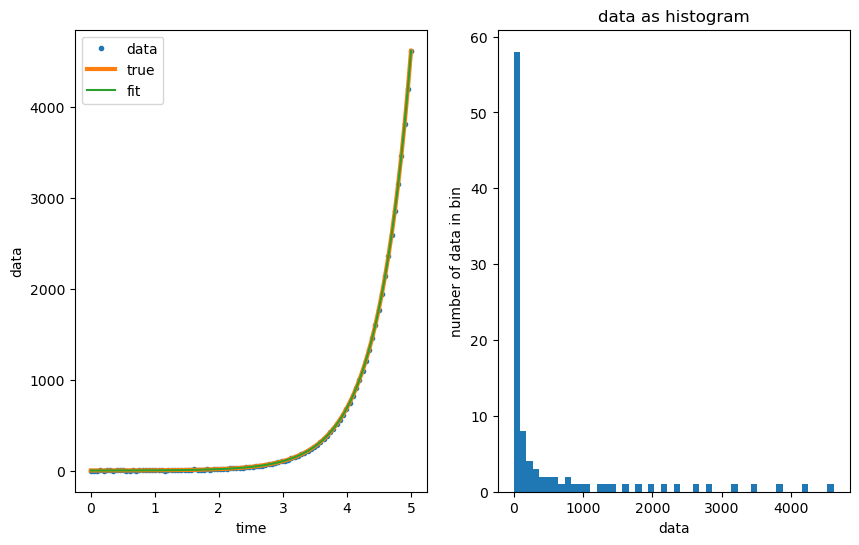

In [668]:
fig, ax = plt.subplots(figsize=(10,6),nrows=1,ncols=2)
ax[0].plot(t, data, '.', label='data')
ax[0].plot(t,A0*np.e**(g0*t), label='true', lw=3)
ax[0].plot(t,fittedparams[0]*np.e**(fittedparams[1]*t), label='fit')
ax[0].legend()
ax[0].set_ylabel("data")
ax[0].set_xlabel("time")
ax[1].title.set_text("data as histogram")
ax[1].set_xlabel("data")
ax[1].set_ylabel("number of data in bin")
ax[1].hist(data, 50)
plt.show()

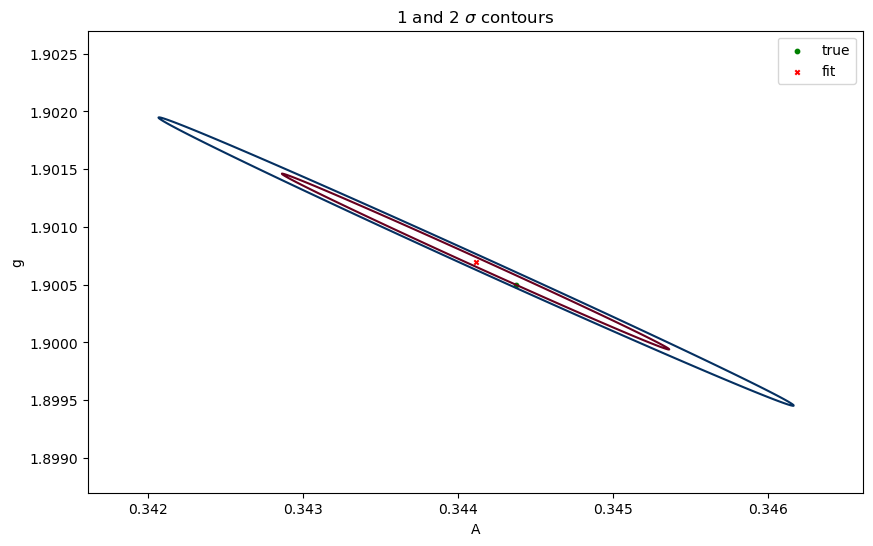

In [669]:
fig,ax=plt.subplots(figsize=(10,6))
ax.contour(A,G,logP,cmap='RdBu',levels=[chi_min_line+2.30,chi_min_line+6.18])
ax.scatter(A0,g0,marker='o',s=10,color='green',label='true')
ax.scatter(fittedparams[0],fittedparams[1],marker='x',s=10,color='red',label='fit')
ax.set(xlabel='A', ylabel='g', title='1 and 2 $\sigma$ contours')
ax.legend()
plt.show()

Note: I was just checking gradescope and HW2 just finished being graded, and I was marked off for saying this contour plot doesn't look good and not explaining why it looks bad. I believe the plot looked really off because the noise was so much larger than the signal. For this project, instead of using $A_0e^{-g_0t}$ I used the originally intended $A_0e^{g_0t}$ as signal. 

Implementation of Metropolis-Hastings Algorithm  
Note: the rng.choice() is a generator function that does the same thing as np.random.choice except it can also return arrays.

In [670]:
def MHA(log_prob_dist, acceptance, proposal, initial_step, numberSteps):
    rejected_steps = []
    accepted_steps = []
    steps = []
    accepted_steps.append(initial_step)
    for i in range(0, numberSteps):
        current_step = accepted_steps[-1]
        proposed_step = proposal(current_step[0], current_step[1])
        acceptance_prob = acceptance(log_prob_dist, proposed_step, current_step)
        rng = np.random.default_rng()
        next_step = rng.choice([proposed_step, current_step], p=[acceptance_prob, 1-acceptance_prob], axis=0)
        if (next_step == current_step).all():
            rejected_steps.append(proposed_step)
        else:
            accepted_steps.append(proposed_step)
    return np.array(accepted_steps), np.array(rejected_steps)

Running the algorithm

In [671]:
numberSteps = 5000
accepted_steps, rejected_steps = MHA(log_probability, acceptance, proposal_distribution, (0.34, 1.9), numberSteps)

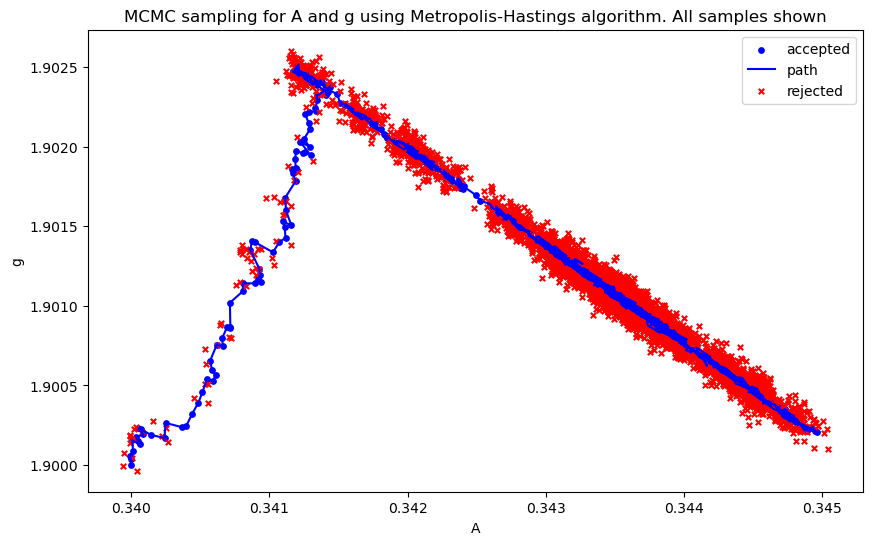

In [672]:
fig,ax=plt.subplots(figsize=(10,6))
acceptedA, acceptedg = np.split(accepted_steps, [1], axis=1)
rejectedA, rejectedg = np.split(rejected_steps, [1], axis=1)

ax.scatter(acceptedA, acceptedg, marker='o', s=15, color='blue', label='accepted')
ax.plot(acceptedA, acceptedg, color='blue', label='path')
ax.scatter(rejectedA, rejectedg, marker='x', s=15, color='red', label='rejected')
ax.set(xlabel='A', ylabel='g', title='MCMC sampling for A and g using Metropolis-Hastings algorithm. All samples shown')
ax.legend()
plt.show()

It can be seen that once the walk makes its way to a region similar to that of the $\chi^2$ confidence intervals, the algorithm starts to heavily reject samples. To show this more clearly, I will consider the first 25% of samples as "burn-in" and discard them.  

Plot of walk with confidence intervals from $\chi^2$ minimization approach.

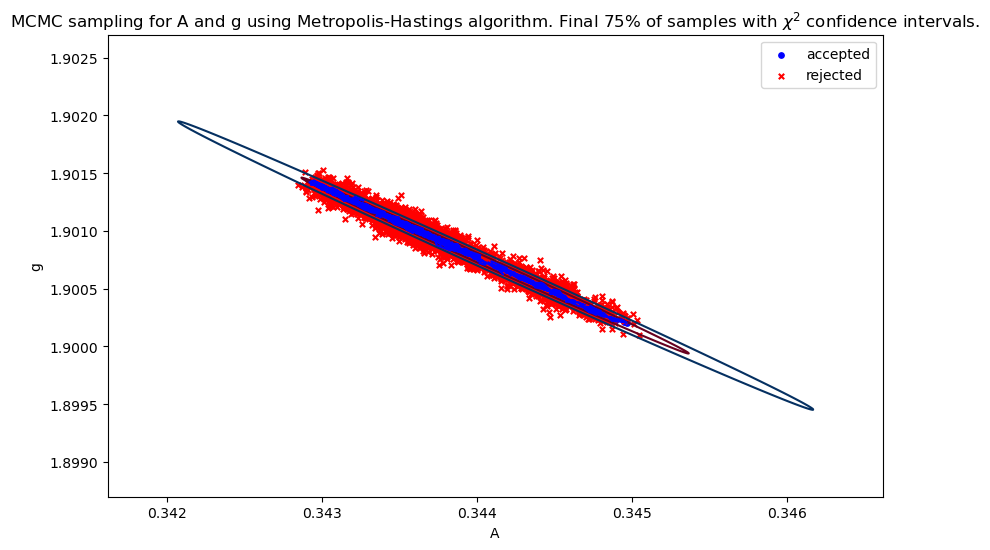

In [673]:
filterAccepted = int(3*accepted_steps.shape[0]/4)
filterRejected = int(3*rejected_steps.shape[0]/4)

nb_AcceptedA = acceptedA[-filterAccepted:]
nb_Acceptedg = acceptedg[-filterAccepted:]
nb_RejectedA = rejectedA[-filterRejected:]
nb_Rejectedg = rejectedg[-filterRejected:]

fig,ax=plt.subplots(figsize=(10,6))
ax.contour(A,G,logP,cmap='RdBu',levels=[chi_min_line+2.30,chi_min_line+6.18])
ax.scatter(nb_AcceptedA, nb_Acceptedg, marker='o', s=15, color='blue', label='accepted')
ax.plot(nb_AcceptedA, nb_Acceptedg, color='blue')
ax.scatter(nb_RejectedA, nb_Rejectedg, marker='x', s=15, color='red', label='rejected')
ax.legend()
ax.set(xlabel='A', ylabel='g', title='MCMC sampling for A and g using Metropolis-Hastings algorithm. Final 75% of samples with $\chi^2$ confidence intervals.')
plt.show()

It can be seen that the walk converges in the area within the $\chi^2$ $1\sigma$ confidence region. This means that the confidence interval from this Markov Chain is matching very similarly to the one from the $\chi^2$ approach. To find the 68% and 95% confidence intervals, I will plot the final 68% and 95% of accepted samples (with burn-in discarded). 

In [674]:
a_r_zoomed = np.linspace(fittedparams[0]-0.0007, fittedparams[0]+0.0007,500)
g_r_zoomed = np.linspace(fittedparams[1]-0.0005, fittedparams[1]+0.0005,500)
Azoomed, Gzoomed = np.meshgrid(a_r_zoomed, g_r_zoomed)
logPzoomed = np.zeros(Azoomed.shape)
for i in range(500):
    for j in range(500):
        logPzoomed[i,j]=chi_squared(Azoomed[i,j],Gzoomed[i,j])

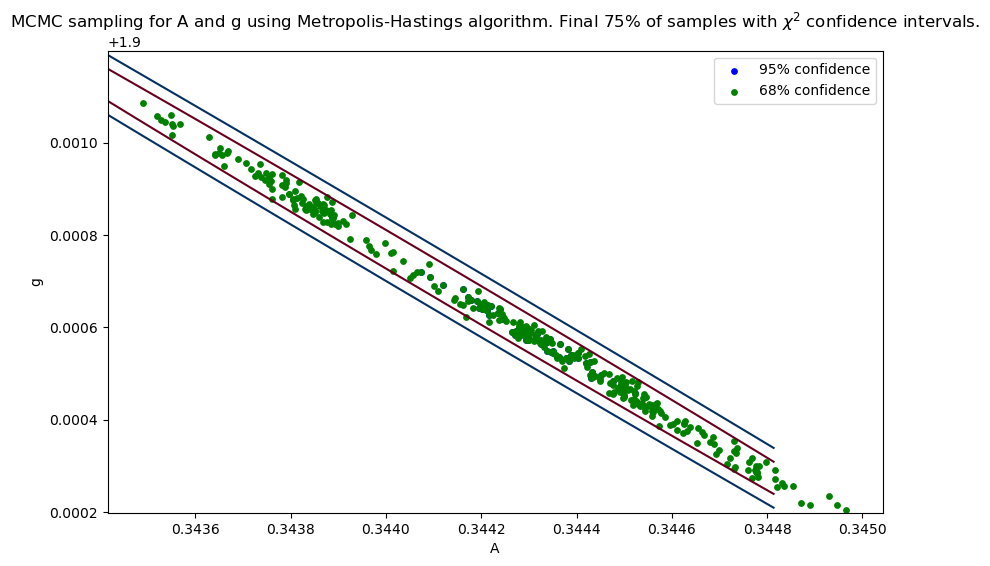

In [675]:
final68 = int(nb_AcceptedA.shape[0] * 0.68)
final95 = int(nb_AcceptedA.shape[0] * 0.95)

fig,ax=plt.subplots(figsize=(10,6))
ax.contour(Azoomed, Gzoomed, logPzoomed, cmap='RdBu', levels=[chi_min_line+2.30, chi_min_line+6.18])
ax.scatter(nb_AcceptedA[final95:], nb_Acceptedg[final95:], marker='o', s=15, color='blue', label='95% confidence')
ax.scatter(nb_AcceptedA[final68:], nb_Acceptedg[final68:], marker='o', s=15, color='green', label='68% confidence')
ax.legend()
ax.set(xlabel='A', ylabel='g', title='MCMC sampling for A and g using Metropolis-Hastings algorithm. Final 75% of samples with $\chi^2$ confidence intervals.')
plt.show()

It can be seen that the final 95% and 68% of accepted samples are all falling within the $\chi^2$ $1\sigma$ confidence region. In order to get the fitted parameter values, I will average the accepted samples. 

In [676]:
MHfittedA = np.average(nb_AcceptedA)
MHfittedg = np.average(nb_Acceptedg)
print(f'Metropolis-Hastings averaged accepted values\nA: {MHfittedA}\ng: {MHfittedg}\n')
print(f'chi-squared minimization values\nA: {fittedparams[0]}\ng: {fittedparams[1]}\n')
print(f'True values\nA = {A0}\ng = {g0}')

Metropolis-Hastings averaged accepted values
A: 0.34371914570814044
g: 1.9009404472211802

chi-squared minimization values
A: 0.3441155166635518
g: 1.9006987351231535

True values
A = 0.34437829223451133
g = 1.9004981138156376


From this comparison and plotted samples, it can be seen that the implementation of the Metropolis-Hastings algorithm is working as intended.  

This concludes my final project.😊👍